In [1]:
import numpy as np
#import Utils.graphTools as graphTools
from scipy import stats

zeroTolerance = 1e-9 # Values below this number are considered zero.
infiniteNumber = 1e12 # infinity equals this number

import numpy as np
import matplotlib.pyplot as plt
from pygsp import graphs, filters, plotting
from pylab import *

plotting.BACKEND = 'matplotlib'
plt.rcParams['figure.figsize'] = (10, 5)

In [2]:
def HannKernel(x, J, R, eMax):
    y = 0.5 + 0.5 * np.cos(2. * np.pi * (J + 1. - R)/(R * eMax) * x  + 2. * np.pi *0.5)
    y[x >= 0] = 0.
    y[x < (-R * eMax/(J + 1. - R))] = 0.
    return y

In [3]:
def tightHannWavelet(E, J, R, eMax, Warping = 'log'):
    """
    Output:
        K (np.array): of shape J x N  contains the J matrices corresponding
            to all the filter scales
    """
    e = E
    N = len(e) # Number of nodes
    # Create wavelets
    H = np.empty([0, N, N])
    K = np.empty([0, N])
    if Warping=='log':
        e +=1e-10
        e = np.log(e) # Warping
        e[np.isnan(e)] = -infiniteNumber
        sumPsiSquared = np.zeros(N) # If there's warping, I have to add all the kernels to build the scaling function (eq. 13)
        eMax = np.log(eMax)
    elif Warping=='csdf':
        e = stats.norm.cdf(G.e)
        eMax = 1
        sumPsiSquared = np.zeros(N) # If there's warping, I have to add all the kernels to build the scaling function (eq. 13)

        
    t = np.arange(1,J+1) * eMax / (J + 1 - R) # translations
    for j in range(0, J-1): # If there is no warping, then we should go all the
        # way to J, but if there's warping, we have to add the scaling function
        # at the beginning
        psi =  HannKernel(e - t[j], J, R, eMax)
        if Warping!= 'NoWarping':
            sumPsiSquared += np.abs(psi) ** 2
        kernel = psi.reshape(1,N)
        K = np.concatenate((K,kernel), axis = 0)

    if Warping != 'NoWarping':
        psi = R * 0.25 + R/2 * 0.25 - sumPsiSquared
        psi[np.abs(psi) < zeroTolerance] = 0
        psi = np.sqrt(psi)
        # Once we built the scaling function, we have to add it at the beginning
        # instead of at the end
        kernel = psi.reshape(1,N)
        K = np.concatenate((K,kernel), axis = 0)

    else:
        psi =  HannKernel(e - t[J-1], J, R, eMax) # If there is no warping,
            # then we can go all the way to use all the scales, so we pick the
            # last value of t that we hadn't use before, and put it last.
        kernel = psi.reshape(1,N)
        K = np.concatenate((K,kernel), axis = 0)

    return K


def fftnoise(f):
    f = np.array(f, dtype='complex')
    Np = (len(f) - 1) // 2
    phases = np.random.randn(Np) * 2 * np.pi
    phases = np.cos(phases) + 1j * np.sin(phases)
    f[1:Np+1] *= phases
    f[-1:-1-Np:-1] = np.conj(f[1:Np+1])
    return np.fft.ifft(f).real


def band_limited_noise(min_freq, max_freq, samples=1024, samplerate=1):
    freqs = np.abs(np.fft.fftfreq(samples, 1/samplerate))
    f = np.ones(samples)
    idx = np.where(np.logical_and(freqs>=min_freq, freqs<=max_freq))[0]
    f[idx] = 1
    return fftnoise(f)



In [4]:
G = graphs.Minnesota()
G.compute_laplacian('combinatorial')
G.compute_fourier_basis() #UeU^*

In [38]:
X1 = np.empty((100,len(G.e)))
X2 = np.empty((100,len(G.e)))
X3 = np.empty((100,len(G.e)))

for i in range(100):
    X1[i,:] = np.random.randn(len(G.e))
    X2[i,:] = band_limited_noise(1, 10, samples=len(G.e), samplerate=10)
    X3[i,:] = np.sin(np.array(range(len(G.e)))/0.7)*np.random.random(1) + np.sin(np.array(range(len(G.e)))/1.1)*np.random.random(1) + np.sin(np.array(range(len(G.e)))/1.5)*np.random.random(1) 

In [66]:
X1.T.shape

(2642, 100)

In [68]:
F_out1 = np.dot(G.U.conj().T,X1.T)
F_out2 = np.dot(G.U.conj().T,X2.T)
F_out3 = np.dot(G.U.conj().T,X3.T)
F_out4 = np.dot(G.U.conj().T,X4.T)

In [44]:
X4 = np.empty((100,len(G.e)))

for i in range(100):
    X4[i,:] = np.sin(np.array(range(len(G.e)))/0.7) + np.sin(np.array(range(len(G.e)))/1.1) + np.sin(np.array(range(len(G.e)))/1.5)

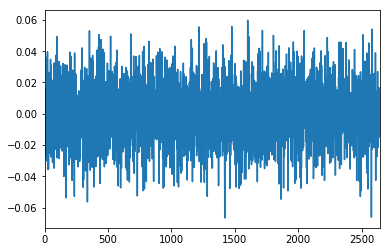

In [135]:
plt.plot(X2[0])
plt.xlim(0,len(G.e))
plt.savefig('sig2')

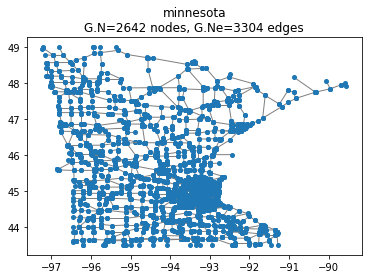

In [9]:
G.plot()

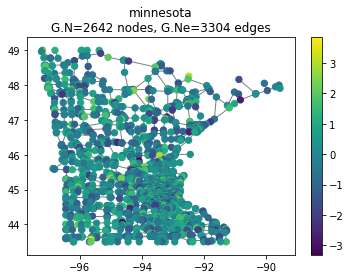

In [137]:
G.plot_signal(X1[99])
plt.savefig('sig1graph')

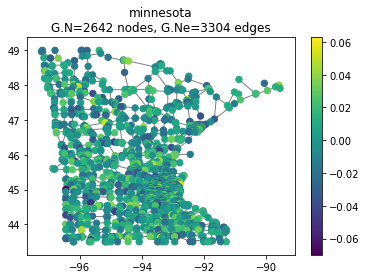

In [138]:
G.plot_signal(X2[0])
plt.savefig('sig2graph')

In [12]:
K = tightHannWavelet(G.e, J = 20, R = 3 , eMax = G.e[-1], Warping = 'csdf' ) # shape : #scales * #nodes

In [13]:
sum_= np.sum(K**2,axis = 0)

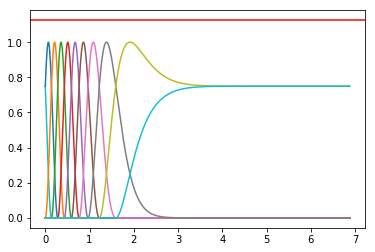

In [14]:
plt.plot(G.e,np.transpose(K))
plt.axhline(y=sum_[0], color='r', linestyle='-')
#plt.xlim(0,50)

In [15]:
E = np.linspace(0,12,100)

'figure()\nplt.hist(G.e, bins = 50)'

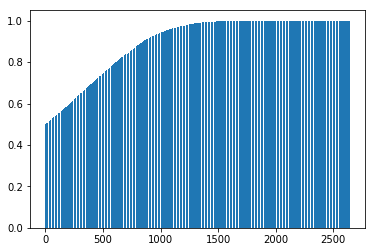

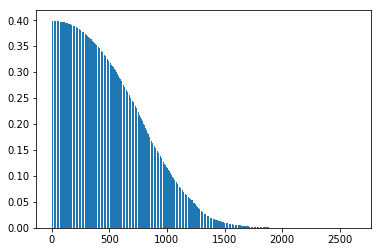

In [16]:
plt.bar(range(len(G.e)),stats.norm.cdf(G.e))
figure()
plt.bar(range(len(G.e)),stats.norm.pdf(G.e))
'''figure()
plt.hist(G.e, bins = 50)'''

# Graph Scattering

In [17]:
def Graph_Scattering(signal):
    phi_0 = np.sum(np.abs(signal))
    
    N = len(signal)
    y_1 = np.empty((N,0)) 

    for j in range(K.shape[0]):
        y_ = np.abs(np.dot(np.dot(G.U,np.dot(np.diag(K[j]),G.U.conj().T)),signal).reshape(N,1))
        y_1 = np.concatenate((y_1,y_), axis = 1)   #y_1 is finally #nodes * #scales
        # K is #scales * #nodes
    phi_1 = np.sum(y_1, axis = 0).reshape(K.shape[0],1)    #scales *1
    y_2 = np.empty((N,K.shape[0],K.shape[0])) # will finally be #nodes * #scales * #scales

    for j in range(K.shape[0]):
        for k in range(K.shape[0]):
            y_2[:,k,j] = np.abs(np.dot(np.dot(G.U,np.dot(np.diag(K[k]),G.U.conj().T)),y_1[:,j]))

    phi_2 = np.sum(y_2, axis = 0).reshape(K.shape[0]*K.shape[0],1) #scales * #scales
    GST_out = np.append(np.append(phi_1,phi_0),phi_2)
    GST_out = GST_out[GST_out!=0]
    return GST_out

In [39]:
GST_out1 = []
GST_out2 = []
GST_out3 = []

In [47]:
GST_out4 = []

for i in range(np.shape(X4)[0]):
    GST_out4.append(Graph_Scattering(X4[i])) 
    print(np.shape(GST_out4))

(1, 133)
(2, 133)
(3, 133)
(4, 133)
(5, 133)
(6, 133)
(7, 133)
(8, 133)
(9, 133)
(10, 133)
(11, 133)
(12, 133)
(13, 133)
(14, 133)
(15, 133)
(16, 133)
(17, 133)
(18, 133)
(19, 133)
(20, 133)
(21, 133)
(22, 133)
(23, 133)
(24, 133)
(25, 133)
(26, 133)
(27, 133)
(28, 133)
(29, 133)
(30, 133)
(31, 133)
(32, 133)
(33, 133)
(34, 133)
(35, 133)
(36, 133)
(37, 133)
(38, 133)
(39, 133)
(40, 133)
(41, 133)
(42, 133)
(43, 133)
(44, 133)
(45, 133)
(46, 133)
(47, 133)
(48, 133)
(49, 133)
(50, 133)
(51, 133)
(52, 133)
(53, 133)
(54, 133)
(55, 133)
(56, 133)
(57, 133)
(58, 133)
(59, 133)
(60, 133)
(61, 133)
(62, 133)
(63, 133)
(64, 133)
(65, 133)
(66, 133)
(67, 133)
(68, 133)
(69, 133)
(70, 133)
(71, 133)
(72, 133)
(73, 133)
(74, 133)
(75, 133)
(76, 133)
(77, 133)
(78, 133)
(79, 133)
(80, 133)
(81, 133)
(82, 133)
(83, 133)
(84, 133)
(85, 133)
(86, 133)
(87, 133)
(88, 133)
(89, 133)
(90, 133)
(91, 133)
(92, 133)
(93, 133)
(94, 133)
(95, 133)
(96, 133)
(97, 133)
(98, 133)
(99, 133)
(100, 133)


In [40]:
for i in range(np.shape(X1)[0]):
    GST_out1.append(Graph_Scattering(X1[i])) 
    print(np.shape(GST_out1))
    GST_out2.append(Graph_Scattering(X2[i]))
    print(np.shape(GST_out2))
    GST_out3.append(Graph_Scattering(X3[i]))
    print(np.shape(GST_out3))

(1, 133)
(1, 133)
(1, 133)
(2, 133)
(2, 133)
(2, 133)
(3, 133)
(3, 133)
(3, 133)
(4, 133)
(4, 133)
(4, 133)
(5, 133)
(5, 133)
(5, 133)
(6, 133)
(6, 133)
(6, 133)
(7, 133)
(7, 133)
(7, 133)
(8, 133)
(8, 133)
(8, 133)
(9, 133)
(9, 133)
(9, 133)
(10, 133)
(10, 133)
(10, 133)
(11, 133)
(11, 133)
(11, 133)
(12, 133)
(12, 133)
(12, 133)
(13, 133)
(13, 133)
(13, 133)
(14, 133)
(14, 133)
(14, 133)
(15, 133)
(15, 133)
(15, 133)
(16, 133)
(16, 133)
(16, 133)
(17, 133)
(17, 133)
(17, 133)
(18, 133)
(18, 133)
(18, 133)
(19, 133)
(19, 133)
(19, 133)
(20, 133)
(20, 133)
(20, 133)
(21, 133)
(21, 133)
(21, 133)
(22, 133)
(22, 133)
(22, 133)
(23, 133)
(23, 133)
(23, 133)
(24, 133)
(24, 133)
(24, 133)
(25, 133)
(25, 133)
(25, 133)
(26, 133)
(26, 133)
(26, 133)
(27, 133)
(27, 133)
(27, 133)
(28, 133)
(28, 133)
(28, 133)
(29, 133)
(29, 133)
(29, 133)
(30, 133)
(30, 133)
(30, 133)
(31, 133)
(31, 133)
(31, 133)
(32, 133)
(32, 133)
(32, 133)
(33, 133)
(33, 133)
(33, 133)
(34, 133)
(34, 133)
(34, 133)
(35, 13

In [43]:
import pickle
# 86 + 54
output = open('GST_out1.pkl', 'wb')
pickle.dump(GST_out1, output)
output.close()
output = open('GST_out2', 'wb')
pickle.dump(GST_out2, output)
output.close()
output = open('GST_out3', 'wb')
pickle.dump(GST_out3, output)
output.close()

In [48]:
output = open('GST_out4', 'wb')
pickle.dump(GST_out4, output)
output.close()

In [30]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import KernelPCA,PCA

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from matplotlib.colors import ListedColormap
from sklearn.manifold import TSNE


from sklearn.linear_model import LogisticRegression
from sklearn import svm
import pandas as pd

In [ ]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(dataset)

In [71]:
np.array(GST_out1).shape

(100, 133)

In [72]:
F_out1.shape

(2642, 100)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 400 samples in 0.001s...
[t-SNE] Computed neighbors for 400 samples in 0.083s...
[t-SNE] Computed conditional probabilities for sample 400 / 400
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.937405
[t-SNE] KL divergence after 300 iterations: 0.344315


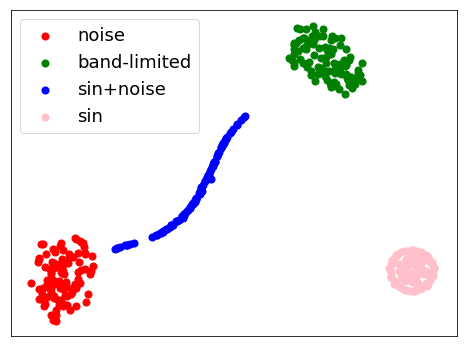

In [110]:

inter_X = GST_out1
inter_Y = np.zeros(len(inter_X))


pre_X = GST_out2
pre_Y = np.ones(len(pre_X))

inter3_X = GST_out3
inter3_Y = np.ones(len(inter3_X))*2

inter4_X = GST_out4
inter4_Y = np.ones(len(inter4_X))*3

X = np.concatenate((inter_X,pre_X,inter3_X,inter4_X))
Y = np.concatenate((inter_Y,pre_Y,inter3_Y,inter4_Y))
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size=0.3, random_state=42)
model1 = svm.SVC(kernel='linear', gamma = 'scale')
model2 = svm.SVC(kernel='rbf', gamma = 'scale')

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X)

model1.fit(tsne_results, Y)
model2.fit(tsne_results, Y)
tsneDf = pd.DataFrame(data = tsne_results, columns = ['tsne 1', 'tsne 2'])


fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(1,1,1) 
finaltsneDf = pd.concat([tsneDf, pd.DataFrame(Y)], axis = 1)


targets = [0, 1, 2, 3]
colors = ['r', 'g', 'b', 'pink']
labels = ['noise','band-limited','sin+noise','sin']
for target, color, label in zip(targets,colors, labels):
    indicesToKeep = finaltsneDf[0] == target
    ax.scatter(finaltsneDf.loc[indicesToKeep, 'tsne 1']
               , finaltsneDf.loc[indicesToKeep, 'tsne 2']
               , c = color, label = label
               , s = 50)
ax.legend(prop = {"size":18})
ax.tick_params(labelsize = 18)
ax.grid()
yticks([])
xticks([])
plt.savefig('tsnegst.png')
plt.show()



In [97]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,r2_score, f1_score
from sklearn import svm


def svc_param_selection(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10]
    gammas = [0.001, 0.01, 0.1, 1]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(svm.SVC(kernel=kernel), param_grid, cv=nfolds,iid = True)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_


rs = 42
CV_score = []
svm_score = []
kernel ='linear'
inter_X = GST_out1
inter_Y = np.zeros(len(inter_X))


pre_X = GST_out2
pre_Y = np.ones(len(pre_X))

inter3_X = GST_out3
inter3_Y = np.ones(len(inter3_X))*2

inter4_X = GST_out4
inter4_Y = np.ones(len(inter4_X))*3

X = np.concatenate((inter_X,pre_X))
Y = np.concatenate((inter_Y,pre_Y))
X = StandardScaler().fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size=0.3, random_state=rs)

mydic = svc_param_selection(X_train, y_train, nfolds = 10)
for key in mydic:
    if key == 'gamma':
        gamma = mydic[key]
    else:
        C = mydic[key]
SVM = svm.SVC(kernel=kernel,gamma=gamma, C =C)
scores_SVMcv = cross_val_score(SVM, X, Y, cv = 10).mean()

Y_pred_svm = SVM.fit(X_train, y_train).predict(X_test)
#svm_score=SVM.score(X_test,y_test)
confusion_matrix(y_test, Y_pred_svm)




array([[31,  0],
       [ 0, 29]])

In [62]:
TN = confusion_matrix(y_test, Y_pred_svm)[0][0]
FP = confusion_matrix(y_test, Y_pred_svm)[0][1]
FN = confusion_matrix(y_test, Y_pred_svm)[1][0]
TP = confusion_matrix(y_test, Y_pred_svm)[1][1]
Accuracy = (TN + TP)/(TN + FP + FN + TP)
Precision = TP / (TP + FP)
Sensitivity = TP / (TP +FN)
Specificity =TN / (TN + FP)
print('True Negative is: ',TN)
print('False Positive is: ',FP)
print('False Negative is: ', FN)
print('True Positive is: ',TP)
print('Accuracy is: ',Accuracy)
print('Precision is: ',Precision)
print('Sensitivity is: ',Sensitivity)
print('Specificity is: ',Specificity)


True Negative is:  31
False Positive is:  0
False Negative is:  0
True Positive is:  29
Accuracy is:  1.0
Precision is:  1.0
Sensitivity is:  1.0
Specificity is:  1.0


# GFT

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 400 samples in 0.060s...
[t-SNE] Computed neighbors for 400 samples in 2.314s...
[t-SNE] Computed conditional probabilities for sample 400 / 400
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 114.835442
[t-SNE] KL divergence after 300 iterations: 4.319567


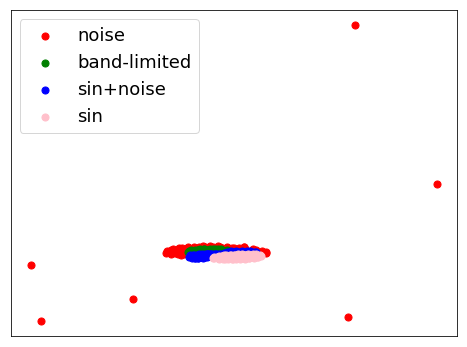

In [112]:

F_X = F_out1.T
F_Y = np.zeros(len(F_X))


F2_X = F_out2.T
F2_Y = np.ones(len(F2_X))

F3_X = F_out3.T
F3_Y = np.ones(len(F3_X))*2

F4_X = F_out4.T
F4_Y = np.ones(len(F4_X))*3

X = np.concatenate((F_X,F2_X,F3_X,F4_X))
Y = np.concatenate((F_Y,F2_Y,F3_Y,F4_Y))
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size=0.3, random_state=42)
model1 = svm.SVC(kernel='linear', gamma = 'scale')
model2 = svm.SVC(kernel='rbf', gamma = 'scale')

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X)

model1.fit(tsne_results, Y)
model2.fit(tsne_results, Y)
tsneDf = pd.DataFrame(data = tsne_results, columns = ['tsne 1', 'tsne 2'])


fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(1,1,1) 
finaltsneDf = pd.concat([tsneDf, pd.DataFrame(Y)], axis = 1)


targets = [0, 1, 2, 3]
colors = ['r', 'g', 'b', 'pink']
labels = ['noise','band-limited','sin+noise','sin']
for target, color, label in zip(targets,colors, labels):
    indicesToKeep = finaltsneDf[0] == target
    ax.scatter(finaltsneDf.loc[indicesToKeep, 'tsne 1']
               , finaltsneDf.loc[indicesToKeep, 'tsne 2']
               , c = color, label = label
               , s = 50)
ax.legend(prop = {"size":18})
ax.tick_params(labelsize = 18)

yticks([])
xticks([])
ax.grid()
plt.savefig('tsneGFT.png')
plt.show()



In [123]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,r2_score, f1_score
from sklearn import svm


def svc_param_selection(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10]
    gammas = [0.001, 0.01, 0.1, 1]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(svm.SVC(kernel=kernel), param_grid, cv=nfolds,iid = True)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_


rs = 10
CV_score = []
svm_score = []
kernel ='linear'
F_X = F_out1.T
F_Y = np.zeros(len(F_X))


F2_X = F_out2.T
F2_Y = np.ones(len(F2_X))

F3_X = F_out3.T
F3_Y = np.ones(len(F3_X))*2

F4_X = F_out4.T
F4_Y = np.ones(len(F4_X))*3

X = np.concatenate((F_X,F2_X))
Y = np.concatenate((F_Y,F2_Y))
X = StandardScaler().fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size=0.3, random_state=rs)

mydic = svc_param_selection(X_train, y_train, nfolds = 10)
for key in mydic:
    if key == 'gamma':
        gamma = mydic[key]
    else:
        C = mydic[key]
SVM = svm.SVC(kernel=kernel,gamma=gamma, C =C)
scores_SVMcv = cross_val_score(SVM, X, Y, cv = 10).mean()

Y_pred_svm = SVM.fit(X_train, y_train).predict(X_test)
#svm_score=SVM.score(X_test,y_test)
confusion_matrix(y_test, Y_pred_svm)




array([[ 0, 34],
       [ 0, 26]])

In [116]:
TN = confusion_matrix(y_test, Y_pred_svm)[0][0]
FP = confusion_matrix(y_test, Y_pred_svm)[0][1]
FN = confusion_matrix(y_test, Y_pred_svm)[1][0]
TP = confusion_matrix(y_test, Y_pred_svm)[1][1]
Accuracy = (TN + TP)/(TN + FP + FN + TP)
Precision = TP / (TP + FP)
Sensitivity = TP / (TP +FN)
Specificity =TN / (TN + FP)
print('True Negative is: ',TN)
print('False Positive is: ',FP)
print('False Negative is: ', FN)
print('True Positive is: ',TP)
print('Accuracy is: ',Accuracy)
print('Precision is: ',Precision)
print('Sensitivity is: ',Sensitivity)
print('Specificity is: ',Specificity)


True Negative is:  0
False Positive is:  34
False Negative is:  0
True Positive is:  26
Accuracy is:  0.43333333333333335
Precision is:  0.43333333333333335
Sensitivity is:  1.0
Specificity is:  0.0
